Notes
- Predator should have several yuck vectors
- Predator not selected strongly enough against for eating venomous prey

In [147]:
import numpy as np
from tqdm import tqdm
import datetime 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, poisson
from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import animation
from IPython.display import HTML

def generate(num_predators, num_venomous_prey, num_mimics, d=2, venom_const=0.5):

    predators_detectors_initial_mean = np.array([1 / np.sqrt(2) for _ in range(d)])
    predators_detectors_initial_cov = 0.4**2 * np.eye(d)
    
    venomous_signals_initial_mean = np.array([-1 / np.sqrt(2), *[-1 / np.sqrt(2) for _ in range(d-1)]])
    venomous_signals_initial_cov = 0.4**2 * np.eye(d)
    
    mimic_signals_initial_mean = np.array([*[-1 / np.sqrt(2) for _ in range(d-1)], 1 / np.sqrt(2)])
    mimic_signals_initial_cov = 0.4**2 * np.eye(d)

    detectors = np.random.multivariate_normal(mean=predators_detectors_initial_mean,
                                              cov=predators_detectors_initial_cov,
                                              size=num_predators)
    venomous_signals = np.random.multivariate_normal(mean=venomous_signals_initial_mean,
                                                     cov=venomous_signals_initial_cov,
                                                     size=num_venomous_prey)
    mimic_signals = np.random.multivariate_normal(mean=mimic_signals_initial_mean,
                                                  cov=mimic_signals_initial_cov,
                                                  size=num_mimics)
    
    signals = np.vstack((venomous_signals, mimic_signals))
    
    risk_tols = np.random.exponential(scale=1000., size=num_predators)
    venom_levels = np.concatenate((np.zeros(num_venomous_prey) + venom_const, np.zeros(num_mimics)))

    return detectors, signals, risk_tols, venom_levels

def similarity(detectors, signals, phenotype_type='vector'):
    match phenotype_type:
        case 'vector':
            dist = np.linalg.norm(detectors[:, np.newaxis] - signals, axis=2)
            return - dist**2
            # cossim = cosine_similarity(detectors, signals)
            # return cossim
        case 'bitstring':
            d = signals.shape[1]
            hamming_distances = np.sum(detectors[:, np.newaxis] != signals, axis=2)
            return 1 - hamming_distances/d
        case _:
            raise NotImplementedError

def calculate_preference_matrix(detectors, signals, risk_tols, phenotype_type='vector'):
    similarity_matrix = similarity(detectors, signals, phenotype_type=phenotype_type) 
    return 1 - np.exp(similarity_matrix / risk_tols[:, np.newaxis])
    
def calculate_predation_matrix(detectors, signals, risk_tols, handling_time, attack_freq, phenotype_type='vector'):
    preference_matrix = calculate_preference_matrix(detectors, signals, risk_tols, phenotype_type)
    n_prey = preference_matrix.shape[1]
    n_effective_prey = preference_matrix.sum(1)
    intake_rates = attack_freq / (1 + attack_freq * handling_time * n_effective_prey)
    return intake_rates[:, None] * preference_matrix

def sample_predators(predation_matrix, venom_levels, pred_conversion_ratio):
    num_predators = predation_matrix.shape[0]
    fitnesses = predation_matrix.sum(1) * np.random.negative_binomial(1, 1 - (1 - (venom_levels * predation_matrix)).prod(1))
    conversion = pred_conversion_ratio / num_predators
    means = conversion * fitnesses
    counts = np.random.poisson(means)
    return np.repeat(np.arange(num_predators), counts)

def sample_prey(predation_matrix, prey_conversion_ratio):
    num_prey = predation_matrix.shape[1]
    fitnesses = (1 - predation_matrix).prod(0)    
    conversion = prey_conversion_ratio / num_prey
    means = conversion * fitnesses
    counts = np.random.poisson(means)
    return np.repeat(np.arange(num_prey), counts)

def phenotype_crossover(phenotypes, parents, phenotype_type='vector'):

    # phenotypes can be signals or detectors
    assert len(parents) % 2 == 0, 'Crossover not implemented yet for odd numbers of parents'
    parent_phenotypes = phenotypes[parents]
    child_phenotypes = np.zeros_like(parent_phenotypes)
    match phenotype_type:
        case 'vector':
            interpolation_values = np.random.rand(parent_phenotypes.shape[0] // 2)[:, np.newaxis]
            child_phenotypes[::2]  = interpolation_values * parent_phenotypes[::2] \
                                    + (1 - interpolation_values) * parent_phenotypes[1::2]
            child_phenotypes[1::2] = (1 - interpolation_values) * parent_phenotypes[::2] \
                                    + interpolation_values * parent_phenotypes[1::2]
            return child_phenotypes
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError
        

def phenotype_mutate(phenotypes, mutation_rate=0.01, phenotype_type='vector'):
    match phenotype_type:
        case 'vector':
            return phenotypes + np.random.normal(scale=mutation_rate, size=phenotypes.shape)
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError

def impose_periodic_boundary(vectors, boundary=5):
    """
    Imposes periodic boundary conditions on an array of 2D vectors.
    
    Parameters:
    vectors (np.array): Array of shape (n, 2) containing 2D vectors.
    boundary (float): The boundary value for both x and y dimensions. Default is 5.
    
    Returns:
    np.array: Array of shape (n, 2) with periodic boundary conditions applied.
    """
    # Ensure the input is a numpy array
    vectors = np.array(vectors)
    
    # Apply periodic boundary conditions
    vectors = np.mod(vectors + boundary, 2 * boundary) - boundary
    
    return vectors


def update(detectors, signals, risk_tols, venom_levels, num_venomous, 
           handling_time=1, attack_freq=2, predator_conversion_ratio=1000, prey_conversion_ratio=10000,
           mutation_rate=0.001, phenotype_type='vector'):

    assert np.all(venom_levels[num_venomous:] == 0), 'A mimic has a non-zero venom level'

    predation_matrix = calculate_predation_matrix(detectors, signals, risk_tols, handling_time, attack_freq, phenotype_type=phenotype_type)

    predator_children = sample_predators(predation_matrix, venom_levels, predator_conversion_ratio)
    prey_children = sample_prey(predation_matrix, prey_conversion_ratio)
    
    predator_children_detectors = detectors[predator_children]
    prey_children_signals = signals[prey_children]
    
    predator_childrens_detectors = phenotype_mutate(predator_children_detectors, mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    prey_childrens_signals = phenotype_mutate(prey_children_signals, mutation_rate=mutation_rate, phenotype_type=phenotype_type)

    predator_children_detectors = impose_periodic_boundary(predator_childrens_detectors, 2)
    prey_childrens_signals = impose_periodic_boundary(prey_childrens_signals, 2)
    
    predator_childrens_risk_tols = phenotype_mutate(risk_tols[predator_children], mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    predator_childrens_risk_tols = abs(predator_childrens_risk_tols)
    # prey_childrens_venoms = phenotype_mutate(venom_levels[prey_children], mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    # prey_childrens_venoms[prey_childrens_venoms > 0.9999] = 0.9999
    # prey_childrens_venoms[prey_childrens_venoms < 0.0001] = 0.0001
    # prey_childrens_venoms[venom_levels[prey_children] == 0] = 0

    prey_childrens_venoms = venom_levels[prey_children]

    new_num_venomous = (prey_childrens_venoms > 0).sum()

    return predator_childrens_detectors, prey_childrens_signals, predator_childrens_risk_tols, prey_childrens_venoms, new_num_venomous

In [151]:
# Initialize population parameters
num_predators = 250
num_venomous_prey = 500
num_mimics = 500
d = 2
venomosity = 1

detectors, signals, risk_tols, venom_levels = generate(num_predators, num_venomous_prey, num_mimics, d, venomosity)

In [154]:
num_generations = 1000
ht = 0.5
af = 2
mutation_rate = 0.1
predator_conversion_ratio = 100
prey_conversion_ratio = 1000

detectors_history    = []
signals_history      = []
risk_tols_history    = []
venom_levels_history = []
nv_history = []

detectors_history.append(detectors)
signals_history.append(signals)
risk_tols_history.append(risk_tols)
venom_levels_history.append(venom_levels)
nv_history.append(num_venomous_prey)

for t in tqdm(range(num_generations)):
    if t % 100 == 0:
        print(f"\n Gen {t}")
        print(f"Predators left: {len(detectors_history[t])}")
        print(f"Venomous Prey left: {nv_history[t]}")
        print(f"Mimic Prey left: {len(signals_history[t]) - nv_history[t]}")
    
    d, s, r, v, nv = update(
        detectors_history[t], 
        signals_history[t], 
        risk_tols_history[t], 
        venom_levels_history[t], 
        nv_history[t], 
        handling_time = ht,
        attack_freq=af,
        predator_conversion_ratio=predator_conversion_ratio,
        prey_conversion_ratio=prey_conversion_ratio,
        mutation_rate=mutation_rate, 
        phenotype_type='vector')
    
    detectors_history.append(d)
    signals_history.append(s)
    risk_tols_history.append(r)
    venom_levels_history.append(v)
    nv_history.append(nv)

    if len(s) == 0:
        break

  1%|▎                                         | 8/1000 [00:00<00:13, 75.48it/s]


 Gen 0
Predators left: 250
Venomous Prey left: 500
Mimic Prey left: 500


 12%|████▋                                  | 120/1000 [00:01<00:07, 114.27it/s]


 Gen 100
Predators left: 123
Venomous Prey left: 503
Mimic Prey left: 381


 22%|████████▌                              | 221/1000 [00:01<00:05, 148.67it/s]


 Gen 200
Predators left: 60
Venomous Prey left: 696
Mimic Prey left: 253


 32%|████████████▌                          | 322/1000 [00:02<00:03, 170.58it/s]


 Gen 300
Predators left: 96
Venomous Prey left: 834
Mimic Prey left: 106


 44%|█████████████████                      | 438/1000 [00:03<00:03, 186.10it/s]


 Gen 400
Predators left: 57
Venomous Prey left: 879
Mimic Prey left: 97


 51%|███████████████████▊                   | 509/1000 [00:03<00:03, 149.40it/s]


 Gen 500
Predators left: 84
Venomous Prey left: 722
Mimic Prey left: 199


 63%|████████████████████████▍              | 628/1000 [00:04<00:01, 197.93it/s]


 Gen 600
Predators left: 66
Venomous Prey left: 942
Mimic Prey left: 17


 73%|████████████████████████████▌          | 733/1000 [00:04<00:01, 203.19it/s]


 Gen 700
Predators left: 76
Venomous Prey left: 1039
Mimic Prey left: 0


 84%|████████████████████████████████▉      | 845/1000 [00:05<00:00, 196.07it/s]


 Gen 800
Predators left: 90
Venomous Prey left: 936
Mimic Prey left: 0


 94%|████████████████████████████████████▌  | 939/1000 [00:06<00:00, 209.59it/s]


 Gen 900
Predators left: 94
Venomous Prey left: 885
Mimic Prey left: 0


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 157.30it/s]


In [ ]:
steps_per_frame = 1
fig = plt.figure(figsize=(4,4))
ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))

def animate(i):
    # Remove old points
    for artist in ax.get_lines()+ax.collections:
        artist.remove()

    t = i * steps_per_frame
    num_venomous_prey = nv_history[t]
    pts = []
    ax.scatter(detectors_history[t][ :, 0], detectors_history[t][ :, 1], color='red', label='predators detectors', s=0.2)
    ax.scatter(signals_history[t][ :num_venomous_prey, 0], signals_history[t][ :num_venomous_prey, 1], color='orange', label='venomous signals', s=0.2, alpha=0.5)
    ax.scatter(signals_history[t][ num_venomous_prey:, 0], signals_history[t][ num_venomous_prey:, 1], color='green', label='mimic signals', s=0.2, alpha=0.5)

    return ax.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(detectors_history)//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('test.gif')
HTML(anim.to_jshtml())

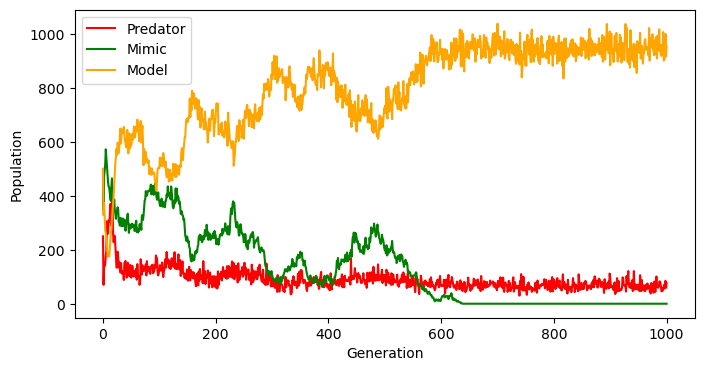

In [155]:
fig, ax = plt.subplots(figsize=(8,4))
n_pred = []
n_mim = []
n_ven = []
for t in range(len(detectors_history)):
    n_pred.append(len(detectors_history[t]))
    n_ven.append(nv_history[t])
    n_mim.append(len(signals_history[t]) - n_ven[-1])

ax.plot(n_pred, '-', c='red', mec='k', label = 'Predator')
ax.plot(n_mim, '-', c='green', mec='k', label = 'Mimic')
ax.plot(n_ven, '-', c='orange', mec='k', label = 'Model')

ax.set_xlabel("Generation")
ax.set_ylabel("Population")
ax.legend()

In [124]:
import numpy as np
from scipy.spatial import cKDTree

def fast_point_cloud_overlap(points1, points2, grid_size=50):
    # Determine the bounds of the grid
    min_x = min(points1[:, 0].min(), points2[:, 0].min())
    max_x = max(points1[:, 0].max(), points2[:, 0].max())
    min_y = min(points1[:, 1].min(), points2[:, 1].min())
    max_y = max(points1[:, 1].max(), points2[:, 0].max())

    # Create a grid
    x = np.linspace(min_x, max_x, grid_size)
    y = np.linspace(min_y, max_y, grid_size)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Use KDTree for efficient nearest neighbor search
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)

    # Compute distances to nearest neighbors
    dist1, _ = tree1.query(grid_points, k=1)
    dist2, _ = tree2.query(grid_points, k=1)

    # Define a radius for considering a point as "occupied"
    radius = min(max_x - min_x, max_y - min_y) / (grid_size * 2)

    # Count overlapping points
    overlap_count = np.sum((dist1 < radius) & (dist2 < radius))
    total_occupied = np.sum((dist1 < radius) | (dist2 < radius))

    # Compute Intersection over Union (IoU)
    iou = overlap_count / total_occupied if total_occupied > 0 else 0

    return iou

# Example usage
np.random.seed(0)
points1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)
points2 = np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], 10000)

overlap = fast_point_cloud_overlap(points1, points2)
print(f"Overlap (IoU): {overlap}")

Overlap (IoU): 0.50997150997151


 72%|████████████████████████████▏          | 724/1001 [00:03<00:01, 215.05it/s]


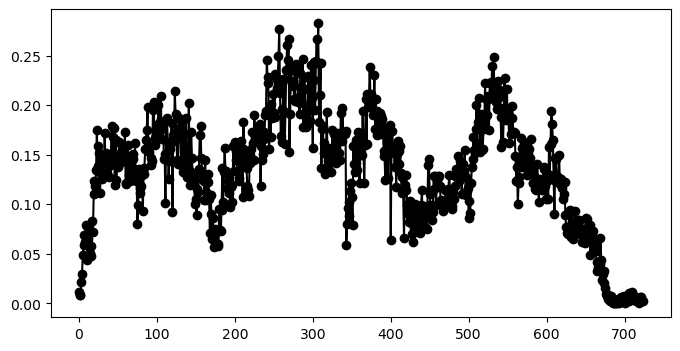

In [125]:
fig, ax = plt.subplots(figsize=(8,4))
overlap = []
for t in tqdm(range(len(detectors_history))):
    signals = signals_history[t]
    nv = nv_history[t]
    m_sigs = signals[nv:]
    v_sigs = signals[:nv]
    try:
        overlap.append(fast_point_cloud_overlap(m_sigs, v_sigs))
    except ValueError:
        break

ax.plot(overlap, '-o', c='k', mec='k')